# 0. 라이브러리 및 데이터 불러오기


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_digits

import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.datasets import mnist

import random

In [2]:
print("library version check")
print("numpy: ", np.__version__)
print("pandas: ", pd.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", mpl.__version__)
print("sklearn: ", sklearn.__version__)
print("tensorflow: ", tensorflow.__version__)

library version check
numpy:  1.23.5
pandas:  1.5.1
seaborn:  0.12.1
matplotlib:  3.6.2
sklearn:  1.1.3
tensorflow:  2.10.0


In [3]:
matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
mpl.style.use("default")
mpl.rcParams.update({"figure.constrained_layout.use": True})

sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

# 1. breast_cancer: 이진분류

In [4]:
cancer = load_breast_cancer()

## 1.1 데이터 전처리

In [5]:
#딥러닝 모델 만들 때는 데이터프레임으로는 fit할 수 없음
x_data = cancer["data"]
y_data = cancer["target"]

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x_data, 
                                                    y_data, 
                                                    test_size = 0.20,
                                                    random_state = 42,
                                                    stratify = y_data)

In [19]:
minmax = MinMaxScaler()
x_train_scaled = minmax.fit_transform(x_train)
x_test_scaled = minmax.transform(x_test)

In [20]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

x_train:  (455, 30)
y_train:  (455,)
x_test:  (114, 30)
y_test:  (114,)


## 1.2 다층 신경망

* gradient vanishing을 방지하기 위한 은닉층의 활성함수는?

* relu
$$
f(x)=\begin{cases}
0 &\text{ if }x\leq0,\\
x &\text{ if }x > 0
\end{cases}
$$

In [21]:
random.seed(42)
# 입력노드 수 = feature 수
input_node = 30
# 출력노드 수
output_node = 1
# 은닉층 노드 수
first_hidden_node = 10

#모델
model_cancer = Sequential(name = "cancer_classifier")
model_cancer.add(Dense(first_hidden_node, 
                       # kernel_initializer='he_normal',
                       activation = "relu", 
                       input_shape=(input_node,) 
                       ))
model_cancer.add(Dense(output_node, 
                       # kernel_initializer='he_normal',
                       activation = "sigmoid"
                      ))


In [22]:
model_cancer.summary()

Model: "cancer_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 10)                310       
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [23]:
adam = Adam(learning_rate=0.01)

model_cancer.compile(loss='binary_crossentropy',
                     optimizer=adam,
                     metrics = ['accuracy'])

In [24]:
model_cancer_hist = model_cancer.fit(x_train_scaled, 
                                     y_train,
                                     epochs=10, 
                                     batch_size=10, 
                                     validation_split=0.2,
                                     # verbose = 1
                                    )

Epoch 1/10
37/37 [==============================] - 3s 24ms/step - loss: 0.5446 - accuracy: 0.8214 - val_loss: 0.4252 - val_accuracy: 0.8352
Epoch 2/10
37/37 [==============================] - 0s 10ms/step - loss: 0.3457 - accuracy: 0.8819 - val_loss: 0.2614 - val_accuracy: 0.9560
Epoch 3/10
37/37 [==============================] - 0s 12ms/step - loss: 0.2480 - accuracy: 0.9011 - val_loss: 0.1978 - val_accuracy: 0.9231
Epoch 4/10
37/37 [==============================] - 0s 12ms/step - loss: 0.2058 - accuracy: 0.9121 - val_loss: 0.1736 - val_accuracy: 0.9560
Epoch 5/10
37/37 [==============================] - 0s 10ms/step - loss: 0.1645 - accuracy: 0.9451 - val_loss: 0.1362 - val_accuracy: 0.9451
Epoch 6/10
37/37 [==============================] - 1s 15ms/step - loss: 0.1474 - accuracy: 0.9451 - val_loss: 0.1315 - val_accuracy: 0.9670
Epoch 7/10
37/37 [==============================] - 1s 13ms/step - loss: 0.1296 - accuracy: 0.9505 - val_loss: 0.1288 - val_accuracy: 0.9670
Epoch 8/10
37

### 학습과정 시각화

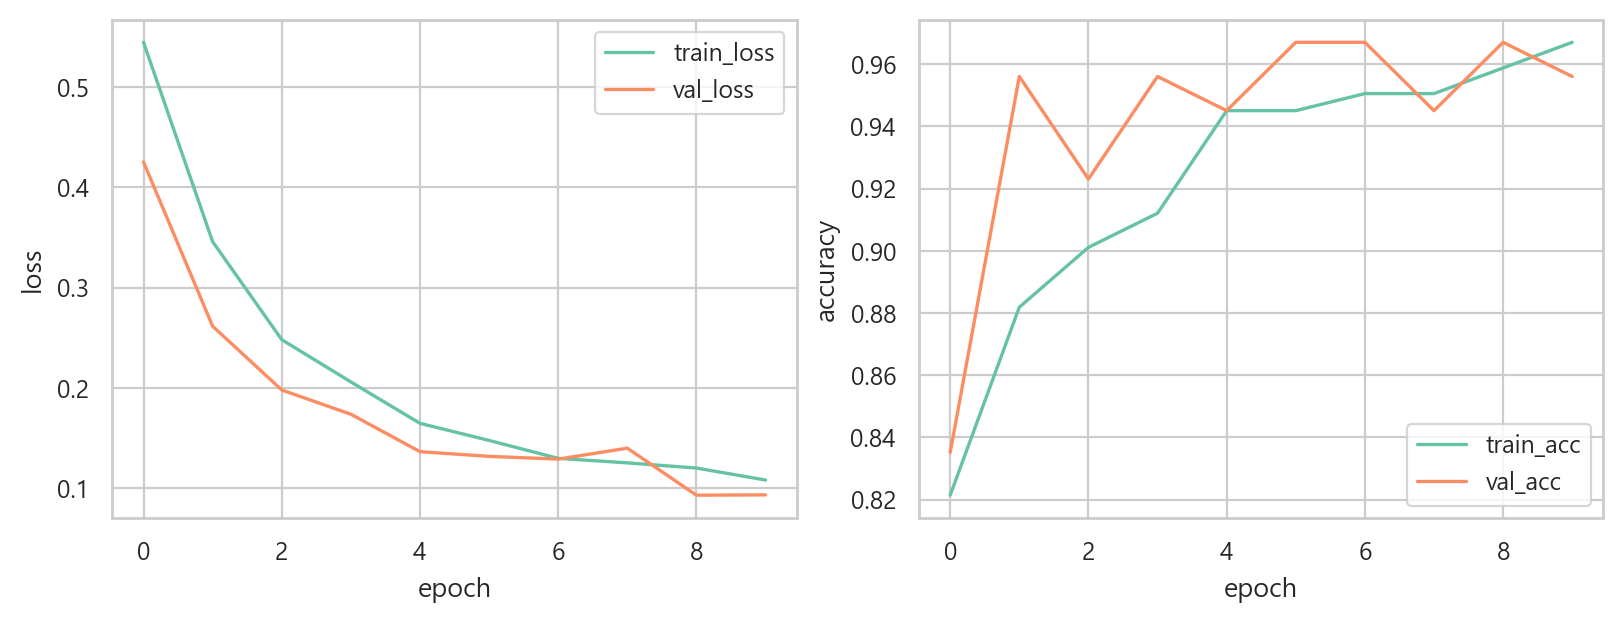

In [25]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize = (8,3))

ax_loss.plot(model_cancer_hist.history["loss"], label="train_loss")
ax_loss.plot(model_cancer_hist.history["val_loss"], label="val_loss")
ax_loss.set(xlabel = "epoch", ylabel = "loss")
ax_loss.legend()

ax_acc.plot(model_cancer_hist.history["accuracy"], label="train_acc")
ax_acc.plot(model_cancer_hist.history["val_accuracy"], label="val_acc")
ax_acc.set(xlabel = "epoch", ylabel = "accuracy")
ax_acc.legend();

### 모델 평가

In [26]:
pred_cancer = model_cancer.predict(x_test_scaled).flatten() >= 0.5

4/4 [==============================] - 0s 5ms/step


In [27]:
metrics.accuracy_score(pred_cancer, y_test)

0.9736842105263158

# 2. Digits: 다중분류

In [28]:
digits = load_digits()

x_data = digits["images"]
y_data = digits["target"]

x_train, x_test, y_train, y_test = train_test_split(x_data, 
                                                    y_data, 
                                                    test_size = 0.20,
                                                    random_state = 42,
                                                    stratify = y_data)

In [29]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

x_train:  (1437, 8, 8)
y_train:  (1437,)
x_test:  (360, 8, 8)
y_test:  (360,)


In [30]:
x_train, x_test = x_train / x_train.max(), x_test / x_train.max()

In [31]:
# 데이터의 shape을 변경해 주자.
x_train_re = np.reshape(x_train, (x_train.shape[0], 64))
x_test_re = np.reshape(x_test, (x_test.shape[0], 64))

In [32]:
# one-hot encoding으로 변경하자. 
y_train = to_categorical(y_train)

In [33]:
print("x_train: ", x_train_re.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test_re.shape)
print("y_test: ", y_test.shape)

x_train:  (1437, 64)
y_train:  (1437, 10)
x_test:  (360, 64)
y_test:  (360,)


In [34]:
random.seed(42)
# 입력노드 수 = feature 수
input_node = 8*8
# 출력노드 수
output_node = 10
# 은닉층 노드 수
first_hidden_node = 16
second_hidden_node = 32

#모델
model_digit = Sequential(name = "digit_classifier")
model_digit.add(Dense(first_hidden_node, 
                       # kernel_initializer='he_normal',
                       activation = "relu", 
                       input_shape=(input_node,) 
                       ))
model_digit.add(Dense(second_hidden_node, 
                       # kernel_initializer='he_normal',
                       activation = "relu"
                      ))
model_digit.add(Dense(output_node, 
                       # kernel_initializer='he_normal',
                       activation = "softmax"
                      ))

In [35]:
model_digit.summary()

Model: "digit_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 16)                1040      
                                                                 
 dense_13 (Dense)            (None, 32)                544       
                                                                 
 dense_14 (Dense)            (None, 10)                330       
                                                                 
Total params: 1,914
Trainable params: 1,914
Non-trainable params: 0
_________________________________________________________________


In [36]:
adam = Adam(learning_rate=0.01)

model_digit.compile(loss='categorical_crossentropy',
                     optimizer=adam,
                     metrics = ['accuracy'])

In [37]:
model_digit_hist = model_digit.fit(x_train_re, 
                                   y_train,
                                   epochs=100, 
                                   batch_size=10, 
                                   validation_split=0.2)

Epoch 1/100
115/115 [==============================] - 3s 10ms/step - loss: 1.0072 - accuracy: 0.6719 - val_loss: 0.4180 - val_accuracy: 0.8611
Epoch 2/100
115/115 [==============================] - 1s 6ms/step - loss: 0.3163 - accuracy: 0.9043 - val_loss: 0.2490 - val_accuracy: 0.9340
Epoch 3/100
115/115 [==============================] - 1s 6ms/step - loss: 0.1928 - accuracy: 0.9356 - val_loss: 0.2629 - val_accuracy: 0.9201
Epoch 4/100
115/115 [==============================] - 1s 8ms/step - loss: 0.1377 - accuracy: 0.9556 - val_loss: 0.3064 - val_accuracy: 0.8993
Epoch 5/100
115/115 [==============================] - 1s 7ms/step - loss: 0.1030 - accuracy: 0.9695 - val_loss: 0.1786 - val_accuracy: 0.9444
Epoch 6/100
115/115 [==============================] - 1s 7ms/step - loss: 0.0997 - accuracy: 0.9617 - val_loss: 0.1805 - val_accuracy: 0.9444
Epoch 7/100
115/115 [==============================] - 1s 6ms/step - loss: 0.0697 - accuracy: 0.9791 - val_loss: 0.1566 - val_accuracy: 0.941

115/115 [==============================] - 1s 7ms/step - loss: 6.0344e-05 - accuracy: 1.0000 - val_loss: 0.0985 - val_accuracy: 0.9688
Epoch 58/100
115/115 [==============================] - 1s 6ms/step - loss: 5.6941e-05 - accuracy: 1.0000 - val_loss: 0.0998 - val_accuracy: 0.9653
Epoch 59/100
115/115 [==============================] - 1s 6ms/step - loss: 5.2967e-05 - accuracy: 1.0000 - val_loss: 0.1003 - val_accuracy: 0.9688
Epoch 60/100
115/115 [==============================] - 1s 6ms/step - loss: 4.9612e-05 - accuracy: 1.0000 - val_loss: 0.1017 - val_accuracy: 0.9688
Epoch 61/100
115/115 [==============================] - 1s 6ms/step - loss: 4.7717e-05 - accuracy: 1.0000 - val_loss: 0.1018 - val_accuracy: 0.9688
Epoch 62/100
115/115 [==============================] - 1s 8ms/step - loss: 4.3992e-05 - accuracy: 1.0000 - val_loss: 0.1021 - val_accuracy: 0.9688
Epoch 63/100
115/115 [==============================] - 1s 6ms/step - loss: 4.1194e-05 - accuracy: 1.0000 - val_loss: 0.1037 

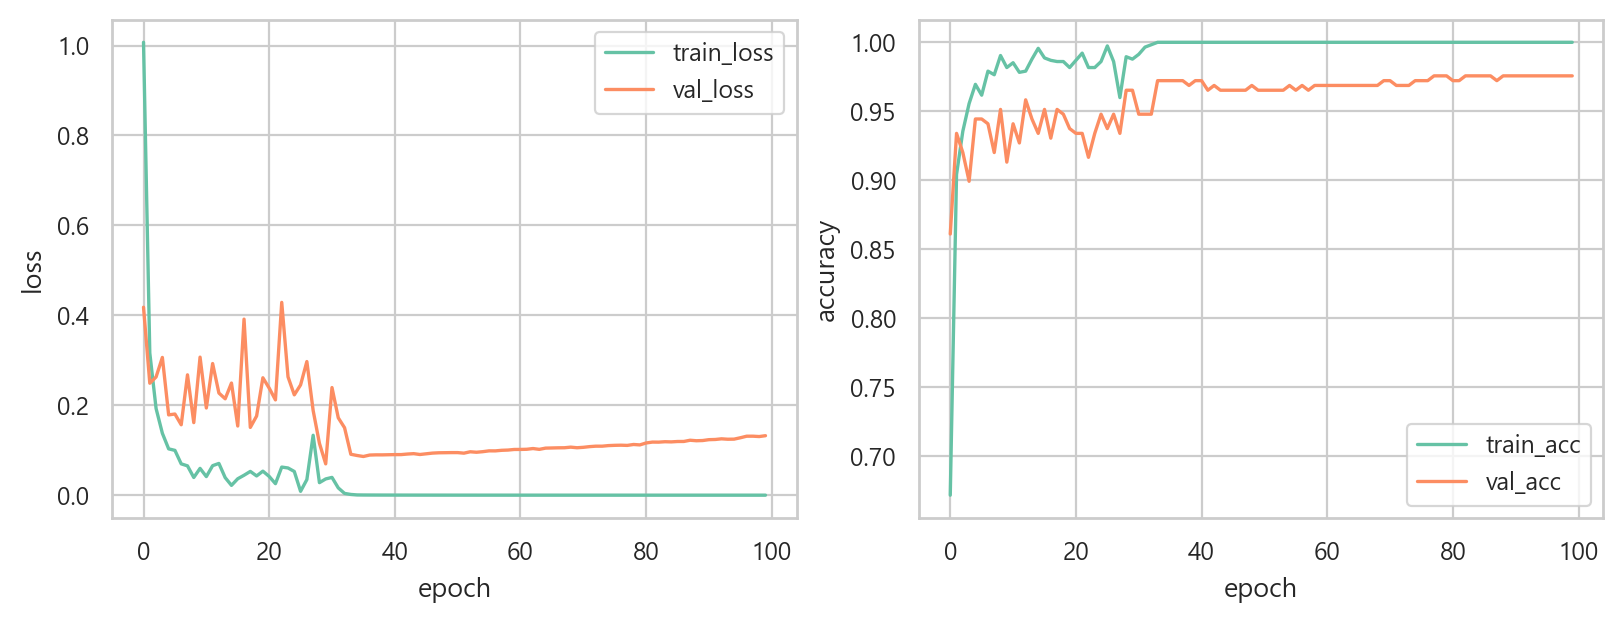

In [38]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize = (8,3))

ax_loss.plot(model_digit_hist.history["loss"], label="train_loss")
ax_loss.plot(model_digit_hist.history["val_loss"], label="val_loss")
ax_loss.set(xlabel = "epoch",
       ylabel = "loss")
ax_loss.legend()

ax_acc.plot(model_digit_hist.history["accuracy"], label="train_acc")
ax_acc.plot(model_digit_hist.history["val_accuracy"], label="val_acc")
ax_acc.set(xlabel = "epoch",
       ylabel = "accuracy")
ax_acc.legend();

In [39]:
metrics.accuracy_score([np.argmax(i) for i in model_digit.predict(x_test_re)], y_test)

12/12 [==============================] - 0s 3ms/step


0.9805555555555555

## 콜백
* 학습 과정 중 어떤 작업(모델 저장이나 조기 종료)을 할 수 있도록 하는 클래스들

**ModelCheckpoint**

* 기본적으로 에포크마다 모델을 저장
* save_best_only = True를 통해 검증 데이터에 대해서 가장 정확도가 높은 모델 저장

In [40]:
random.seed(42)
# 입력노드 수 = feature 수
input_node = 8*8
# 출력노드 수
output_node = 10
# 은닉층 노드 수
first_hidden_node = 16
second_hidden_node = 32

#모델
model_digit = Sequential(name = "digit_classifier")
model_digit.add(Dense(first_hidden_node, 
                       # kernel_initializer='he_normal',
                       activation = "relu", 
                       input_shape=(input_node,) 
                       ))
model_digit.add(Dense(second_hidden_node, 
                       # kernel_initializer='he_normal',
                       activation = "relu"
                      ))
model_digit.add(Dense(output_node, 
                       # kernel_initializer='he_normal',
                       activation = "softmax"
                      ))

In [41]:
adam = Adam(learning_rate=0.01)

model_digit.compile(loss='categorical_crossentropy',
                     optimizer=adam,
                     metrics = ['accuracy'])

# 학습 중 검증 데이터에 대해서 가장 정확도가 높은 모델 저장
# checkpoint = ModelCheckpoint("../model/digit_classifier_best_01.h5",
#                              save_best_only = True)

In [42]:
model_digit_hist = model_digit.fit(x_train_re, 
                                   y_train,
                                   epochs=100, 
                                   batch_size=10, 
                                   validation_split=0.2,
                                   callbacks=[checkpoint])

Epoch 1/100
115/115 [==============================] - 3s 11ms/step - loss: 1.0737 - accuracy: 0.6301 - val_loss: 0.5176 - val_accuracy: 0.8194
Epoch 2/100
115/115 [==============================] - 1s 7ms/step - loss: 0.3664 - accuracy: 0.8842 - val_loss: 0.3666 - val_accuracy: 0.8750
Epoch 3/100
115/115 [==============================] - 1s 9ms/step - loss: 0.2204 - accuracy: 0.9243 - val_loss: 0.2880 - val_accuracy: 0.9132
Epoch 4/100
115/115 [==============================] - 1s 9ms/step - loss: 0.1696 - accuracy: 0.9478 - val_loss: 0.2050 - val_accuracy: 0.9479
Epoch 5/100
115/115 [==============================] - 1s 8ms/step - loss: 0.1657 - accuracy: 0.9399 - val_loss: 0.2270 - val_accuracy: 0.9167
Epoch 6/100
115/115 [==============================] - 1s 8ms/step - loss: 0.1298 - accuracy: 0.9582 - val_loss: 0.1886 - val_accuracy: 0.9375
Epoch 7/100
115/115 [==============================] - 1s 6ms/step - loss: 0.1060 - accuracy: 0.9678 - val_loss: 0.2103 - val_accuracy: 0.937

115/115 [==============================] - 1s 7ms/step - loss: 8.9019e-05 - accuracy: 1.0000 - val_loss: 0.1993 - val_accuracy: 0.9618
Epoch 58/100
115/115 [==============================] - 1s 7ms/step - loss: 8.2995e-05 - accuracy: 1.0000 - val_loss: 0.1995 - val_accuracy: 0.9618
Epoch 59/100
115/115 [==============================] - 1s 7ms/step - loss: 7.6460e-05 - accuracy: 1.0000 - val_loss: 0.1992 - val_accuracy: 0.9618
Epoch 60/100
115/115 [==============================] - 1s 7ms/step - loss: 7.1752e-05 - accuracy: 1.0000 - val_loss: 0.1997 - val_accuracy: 0.9618
Epoch 61/100
115/115 [==============================] - 1s 6ms/step - loss: 6.6847e-05 - accuracy: 1.0000 - val_loss: 0.1998 - val_accuracy: 0.9618
Epoch 62/100
115/115 [==============================] - 1s 9ms/step - loss: 6.2583e-05 - accuracy: 1.0000 - val_loss: 0.1998 - val_accuracy: 0.9618
Epoch 63/100
115/115 [==============================] - 1s 7ms/step - loss: 5.8617e-05 - accuracy: 1.0000 - val_loss: 0.2003 

In [43]:
# model = load_model("../model/digit_classifier_best_01.h5")

In [44]:
# model.summary()

Model: "digit_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 16)                1040      
                                                                 
 dense_16 (Dense)            (None, 32)                544       
                                                                 
 dense_17 (Dense)            (None, 10)                330       
                                                                 
Total params: 1,914
Trainable params: 1,914
Non-trainable params: 0
_________________________________________________________________


In [45]:
metrics.accuracy_score([np.argmax(i) for i in model.predict(x_test_re)], y_test)

12/12 [==============================] - 0s 4ms/step


0.9638888888888889

**EarlyStopping**

* validataion loss가 상승하면 모델이 과대적합(학습 데이터에는 정확도가 높지만 검증이나 테스트에서 정확도가 낮음)되고 있다는 의미
* validation loss가 상승하기 시작하면 더이상 학습을 진행하는 것은 의미가 없음
* validation loss가 상승하면 학습을 멈추도록 설정할 수 있음

* patience = 2: 연속 2번 validation loss가 줄지 않으면 학습을 멈춤
* restore_best_weights = True면가장 낮은 validation loss가 되었던 모델 파라미터로 되돌림

In [56]:
random.seed(42)
# 입력노드 수 = feature 수
input_node = 8*8
# 출력노드 수
output_node = 10
# 은닉층 노드 수
first_hidden_node = 16
second_hidden_node = 32

#모델
model_digit = Sequential(name = "digit_classifier")
model_digit.add(Dense(first_hidden_node, 
                       # kernel_initializer='he_normal',
                       activation = "relu", 
                       input_shape=(input_node,) 
                       ))
model_digit.add(Dense(second_hidden_node, 
                       # kernel_initializer='he_normal',
                       activation = "relu"
                      ))
model_digit.add(Dense(output_node, 
                       # kernel_initializer='he_normal',
                       activation = "softmax"
                      ))

In [57]:
adam = Adam(learning_rate=0.01)

model_digit.compile(loss='categorical_crossentropy',
                     optimizer=adam,
                     metrics = ['accuracy'])

# 학습 중 검증 데이터에 대해서 가장 정확도가 높은 모델 저장
# checkpoint = ModelCheckpoint("../model/digit_classifier_best_02.h5",
#                              save_best_only = True)

# validation loss가 연속 2번 감소하지 않으면 조기종료
early_stopping = EarlyStopping(patience = 2,
                              restore_best_weights=True)

In [58]:
model_digit_hist = model_digit.fit(x_train_re, 
                                   y_train,
                                   epochs=100, 
                                   batch_size=10, 
                                   validation_split=0.2,
                                   callbacks=[checkpoint, early_stopping])

Epoch 1/100
115/115 [==============================] - 3s 14ms/step - loss: 0.9825 - accuracy: 0.6849 - val_loss: 0.5846 - val_accuracy: 0.7882
Epoch 2/100
115/115 [==============================] - 1s 11ms/step - loss: 0.3099 - accuracy: 0.8999 - val_loss: 0.2889 - val_accuracy: 0.8958
Epoch 3/100
115/115 [==============================] - 1s 8ms/step - loss: 0.1818 - accuracy: 0.9426 - val_loss: 0.1690 - val_accuracy: 0.9479
Epoch 4/100
115/115 [==============================] - 1s 7ms/step - loss: 0.1603 - accuracy: 0.9452 - val_loss: 0.2854 - val_accuracy: 0.9097
Epoch 5/100
115/115 [==============================] - 1s 6ms/step - loss: 0.1322 - accuracy: 0.9591 - val_loss: 0.2097 - val_accuracy: 0.9236


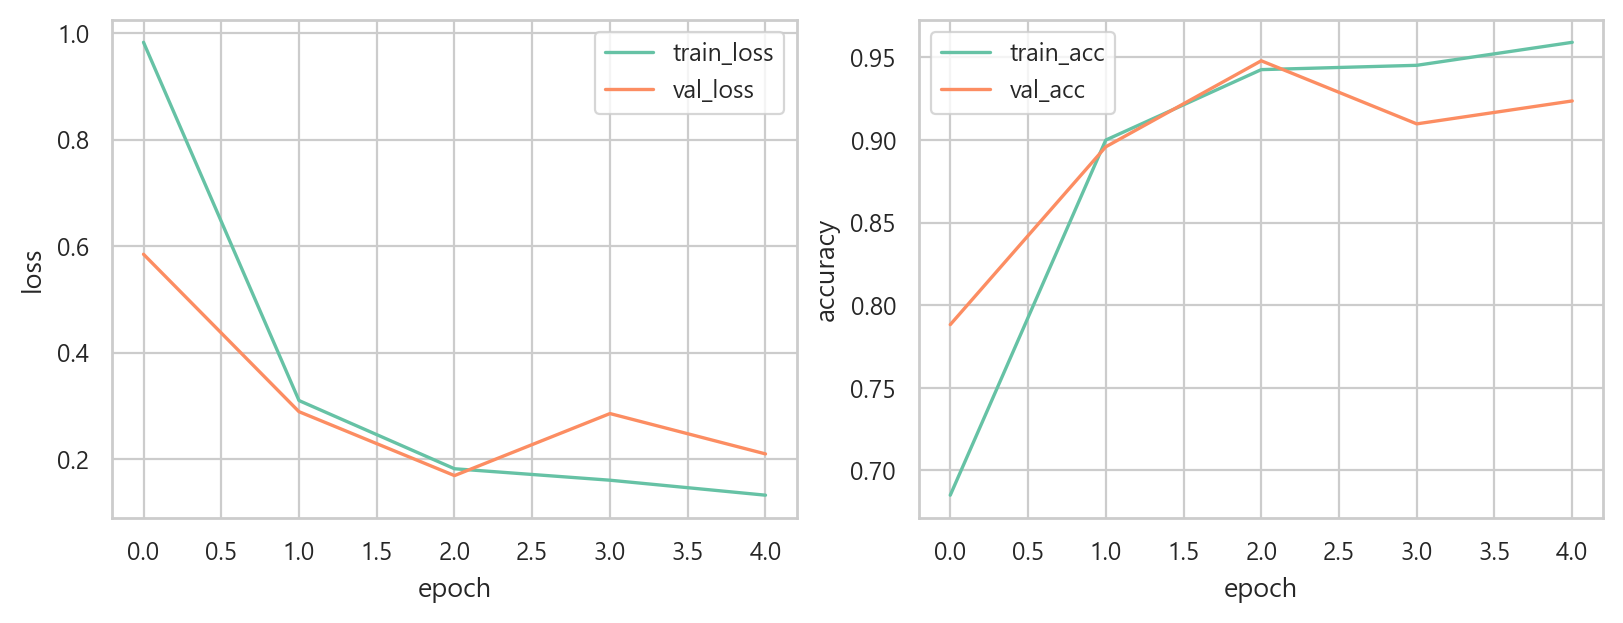

In [59]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize = (8,3))

ax_loss.plot(model_digit_hist.history["loss"], label="train_loss")
ax_loss.plot(model_digit_hist.history["val_loss"], label="val_loss")
ax_loss.set(xlabel = "epoch",
       ylabel = "loss")
ax_loss.legend()

ax_acc.plot(model_digit_hist.history["accuracy"], label="train_acc")
ax_acc.plot(model_digit_hist.history["val_accuracy"], label="val_acc")
ax_acc.set(xlabel = "epoch",
       ylabel = "accuracy")
ax_acc.legend();

# MNIST

In [60]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [61]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

x_train:  (60000, 28, 28)
y_train:  (60000,)
x_test:  (10000, 28, 28)
y_test:  (10000,)


In [62]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949],
       dtype=int64))

In [63]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009],
       dtype=int64))

In [72]:
i = 42
plt.imshow(x_train[i])
print("index: ", i, "image의 숫자: ", y_train[i]);

In [65]:
print(x_train.min(), x_train.max())

0 255


In [66]:
# min-max scaling
x_train, x_test = x_train / x_train.max(), x_test / x_train.max()

In [67]:
## 데이터의 shape을 변경해 주자.
x_train_re = np.reshape(x_train, (x_train.shape[0], 28*28))
x_test_re = np.reshape(x_test, (x_test.shape[0], 28*28))

In [68]:
## one-hot encoding으로 변경하자. 
y_train = to_categorical(y_train)

## RFC

In [69]:
print("x_train: ", x_train_re.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test_re.shape)
print("y_test: ", y_test.shape)

x_train:  (60000, 784)
y_train:  (60000, 10)
x_test:  (10000, 784)
y_test:  (10000,)


In [70]:
# 오래 걸린다!
#rfc = RandomForestClassifier(oob_score=True, random_state=209) 
#rfc.fit(x_train_re, y_train)

RandomForestClassifier(oob_score=True, random_state=209)

In [71]:
# metrics.accuracy_score( [np.argmax(i) for i in rfc.predict(x_test_re)], y_test)

0.9042

## 다층 신경망

In [78]:
## 은닉층이 2개인 mnist_classifier를 만드시오.

random.seed(42)
# 입력노드 수 = feature 수
input_node = 28*28
# 출력노드 수
output_node = 10
# 은닉층 노드 수
first_hidden_node = 128
second_hidden_node = 64

#모델
model_mnist = Sequential(name = "mnist_classifier")
model_mnist.add(Dense(first_hidden_node, 
                       kernel_initializer='he_normal',
                       activation = "relu", 
                       input_shape=(input_node,) 
                       ))
model_mnist.add(Dense(second_hidden_node, 
                       kernel_initializer='he_normal',
                       activation = "relu"
                      ))
model_mnist.add(Dense(output_node, 
                       kernel_initializer='he_normal',
                       activation = "softmax"
                      ))

In [79]:
adam = Adam(learning_rate=0.001)

model_mnist.compile(loss='categorical_crossentropy',
                     optimizer=adam,
                     metrics = ['accuracy'])

# 학습 중 검증 데이터에 대해서 가장 정확도가 높은 모델 저장
checkpoint = ModelCheckpoint("../model/mnist_classifier_best_02.h5",
                             save_best_only = True)

# validation loss가 연속 2번 감소하지 않으면 조기종료
early_stopping = EarlyStopping(patience = 2,
                              restore_best_weights=True)

In [80]:
model_mnist_hist = model_mnist.fit(x_train_re, 
                                   y_train,
                                   epochs=100, 
                                   batch_size=100, 
                                   validation_split=0.2,
                                   callbacks=[checkpoint, early_stopping])

Epoch 1/100
480/480 [==============================] - 11s 13ms/step - loss: 0.3407 - accuracy: 0.9040 - val_loss: 0.1582 - val_accuracy: 0.9557
Epoch 2/100
480/480 [==============================] - 5s 10ms/step - loss: 0.1330 - accuracy: 0.9610 - val_loss: 0.1311 - val_accuracy: 0.9608
Epoch 3/100
480/480 [==============================] - 5s 10ms/step - loss: 0.0929 - accuracy: 0.9729 - val_loss: 0.1086 - val_accuracy: 0.9682
Epoch 4/100
480/480 [==============================] - 5s 10ms/step - loss: 0.0694 - accuracy: 0.9793 - val_loss: 0.1121 - val_accuracy: 0.9679
Epoch 5/100
480/480 [==============================] - 5s 10ms/step - loss: 0.0545 - accuracy: 0.9832 - val_loss: 0.0826 - val_accuracy: 0.9759
Epoch 6/100
480/480 [==============================] - 5s 11ms/step - loss: 0.0416 - accuracy: 0.9874 - val_loss: 0.0894 - val_accuracy: 0.9740
Epoch 7/100
480/480 [==============================] - 5s 11ms/step - loss: 0.0330 - accuracy: 0.9899 - val_loss: 0.0916 - val_accuracy

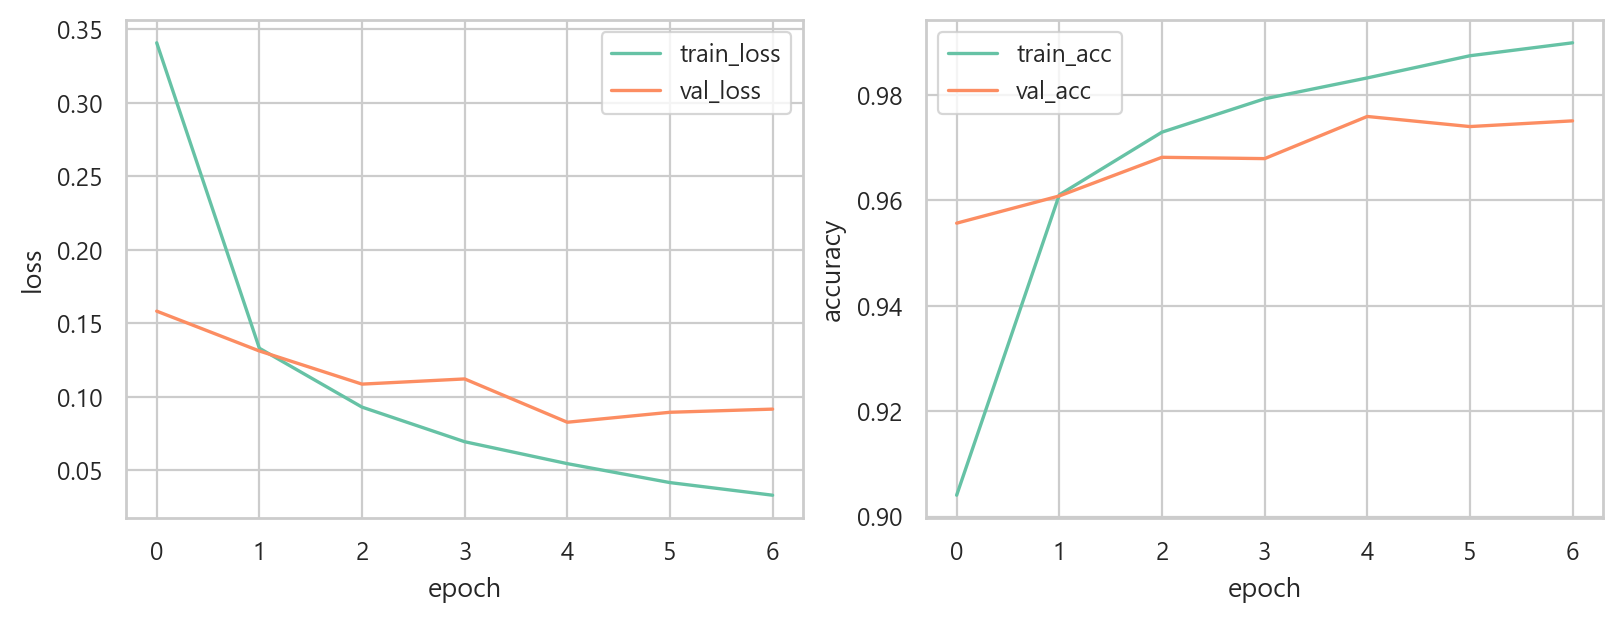

In [81]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize = (8,3))

ax_loss.plot(model_mnist_hist.history["loss"], label="train_loss")
ax_loss.plot(model_mnist_hist.history["val_loss"], label="val_loss")
ax_loss.set(xlabel = "epoch",
       ylabel = "loss")
ax_loss.legend()

ax_acc.plot(model_mnist_hist.history["accuracy"], label="train_acc")
ax_acc.plot(model_mnist_hist.history["val_accuracy"], label="val_acc")
ax_acc.set(xlabel = "epoch",
       ylabel = "accuracy")
ax_acc.legend();

In [82]:
metrics.accuracy_score([np.argmax(i) for i in model_mnist.predict(x_test_re)], y_test)

313/313 [==============================] - 2s 5ms/step


0.9773

# 240530 과제

1. HR 데이터에 단층 신경망을 적용하여 정확도를 측정하시오.
2. HR 데이터에 다층 신경망을 적용하여 정확도를 측정하시오.